# <strong>Import Library

In [1]:
import tensorflow as tf
import pandas as pd

import cv2
import os
import shutil
import random
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report , confusion_matrix

In [2]:
# LIMIT GPU ALLOCATION
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  

In [3]:
import os
os.getcwd()  , os.listdir()    # GET CURRENT DIRECTORY

('c:\\Tensorflow\\Image Classification\\Transfer Learning',
 ['ImageModelWithTransferLearning.ipynb',
  'Inception_v3.h5',
  'inception_v3.ipynb'])

# <strong>Pre-Processing Data

## <strong> Set Path

In [ ]:
# CREATE STRUCTURE DATASET

#base_dir = '/kaggle/working/'
#base_dir

#train_dir = os.path.join(base_dir,'train')
#test_dir = os.path.join(base_dir, 'test')

# MAKE SUBFOLDER FOR TRAINING IMAGE
#os.makedirs(os.path.join(train_dir,'cats'),exist_ok=True)
#os.makedirs(os.path.join(train_dir,'dogs'),exist_ok=True)
#os.makedirs(os.path.join(train_dir,'snakes'),exist_ok=True)

## MAKE SUBFOLDER FOR TESTING IMAGE
#os.makedirs(os.path.join(test_dir,'cats'),exist_ok=True)
#os.makedirs(os.path.join(test_dir,'dogs'),exist_ok=True)
#os.makedirs(os.path.join(test_dir,'snakes'),exist_ok=True)

In [ ]:
# THIS CELL IS TO SPLIT IMAGE INTO 2 SUBFOLDER (TRAIN AND TEST)

#from sklearn.model_selection import train_test_split
#import shutil

#source_dir = '/kaggle/input/animal-image-classification-dataset/Animals'
#animals = ['cats','dogs','snakes']

#for animal in animals: # MOVE FILE FOR EACH ANIMAL CLASS
#    animals_path = os.path.join(source_dir, animal) # PATH FOR EVERY SUBFOLDER CATEGORY
#    scan_all_files = os.listdir(animals_path)  #SCAN AND GET IMAGE IN ANIMAL FOLDER

    #SPLIT ANIMAL FILES INTO TRAIN AND TEST
#    train_files , test_files = train_test_split(scan_all_files,test_size=0.2,random_state=21,shuffle=True) 
#
#   for filename in train_files: 
#        #COPY EACH FILE FROM REAL ANIMAL FOLDER TO TRAIN ANIMAL FOLDER
#        shutil.copy(os.path.join(animals_path,filename),os.path.join(train_dir,animal)) #COPY EACH FILE FROM REAL ANIMAL FOLDER TO TRAIN ANIMAL FOLDER
#
#    for filename in test_files:
#        #COPY EACH FILE FROM ANIMAL FOLDER TO TEST ANIMAL FOLDER
#        shutil.copy(os.path.join(animals_path,filename),os.path.join(test_dir,animal))

In [ ]:
import os

# DATASET DIRECTORY LOCATION
base_dir = '/kaggle/working/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# LABEL 
class_names = ['cats', 'dogs', 'snakes']

# ITERATE EVERY LABEL
for class_name in class_names:
    
    # PATH TO THE CLASS NAME
    train_class_dir = os.path.join(train_dir, class_name)

    # COUNT NUMBER OF IMAGE IN TRAIN DIRECTORY
    num_train_images = len([f for f in os.listdir(train_class_dir) if os.path.isfile(os.path.join(train_class_dir, f))])
    
    # COUNT NUMBER OF IMAGE IN TEST DIRECTORY
    test_class_dir = os.path.join(test_dir, class_name)
    num_test_images = len([f for f in os.listdir(test_class_dir) if os.path.isfile(os.path.join(test_class_dir, f))])
    
    # DISPLAY RESULT
    print(f"Number of class : {class_name}:")
    print(f"  Training set: {num_train_images} gambar")
    print(f"  Testing set: {num_test_images} gambar")
    print("-" * 40)

In [2]:
# IMPORT DATASET

DIRECTORY = '../Animals'

# DECLARE TRAIN DATASET FROM TRAIN DIRECTORY PATH
TRAIN_DIR = os.path.join(DIRECTORY , 'train')

#DECLARE TEST DATASET FROM TEST DIRECTORY PATH
VALIDATION_DIR = os.path.join(DIRECTORY , 'test')

TRAIN_DIR  , VALIDATION_DIR

('../Animals\\train', '../Animals\\test')

## <strong>Check Corrupted/Broken images

ok lets we check if there broken/corrupted image

In [3]:
# CHECK CORRUPTED IMAGE

import os
from PIL import Image

def check_images_in_directory(directory_path):
    
    corrupted_images = []
    
    # ITERATE THROUGH DIRECTORY AND ITS SUB-DIRECTORY
    for subdir, _, files in os.walk(directory_path):
        for filename in files:

            # CHECK IMAGE FILE
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(subdir, filename)
                
                try:
                    # OPEN IMAGE
                    with Image.open(file_path) as img:
                        img.verify()                # VERIFY IF ITS CORRUPTED
                        
                except (IOError, SyntaxError) as e:
                    
                    print(f"Corrupted: {file_path}")
                    corrupted_images.append(file_path)
    
    return corrupted_images

# PATH
dataset_path = r'C:\Tensorflow\Image Classification\Animals'

# EXECUTION
corrupted_files = check_images_in_directory(dataset_path)

# DISPLAY RESULT
if corrupted_files:
    print(f"\nCorrupted images found: {len(corrupted_files)}")
    for file in corrupted_files:
        print(file)
else:
    print("No corrupted images found.")


No corrupted images found.


## <strong> Check Blurry Images

In [ ]:
# CHECK BLURRY IMAGE

def is_image_blurry(image_path, threshold=40):

    # IF IMAGE NOT EXIST
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return False
        
    # READ IMAGE
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Failed to load image: {image_path}")
        return False

    # CHANGE IMAGE TO GRAYSCALE COLOR
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CALCULATE LAPLACIAN FILTER
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    variance = laplacian.var()
    
    return variance < threshold  # IF VARIANCE < THRESHOLD , THEN THE IMAGE IS BLURRY

# FUNCTION TO ACCESS IMAGES WITHIN DATASET
def check_images_and_collect_blurry(directory_path):
    
    blurry_images = []

    # ACCESS ALL SUBDIRECTORY
    for subdir, _, files in os.walk(directory_path):

        # IF FOUND A FILE
        for filename in files:

            # IF A FILE IS IMAGE
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')): 
                file_path = os.path.join(subdir, filename)

                # CHECK BLURRY IMAGE
                if is_image_blurry(file_path):
                    #print(f"Blurry: {file_path}")
                    blurry_images.append(file_path)
                else:
                    #print(f"Clear: {file_path}")
                    continue
    
    return blurry_images

# PATH
dataset_path = r'/kaggle/working/'

# BLURRY IMAGES FROM TRAIN FOLDER
blurry_train_images = check_images_and_collect_blurry(os.path.join(dataset_path, 'train'))

# BLURRY IMAGES FROM TEST FOLDER
blurry_test_images = check_images_and_collect_blurry(os.path.join(dataset_path, 'test'))

all_blurry_images = blurry_train_images + blurry_test_images


In [ ]:
# DISPLAY ALL BLURRY IMAGES (IF ANY)

def display_blurry_images(blurry_images):

    # IF DOESN'T HAVE BLURRY IMAGE
    if len(blurry_images) == 0:
        print("No blurry images found.")
        return

    
    fig, axes = plt.subplots(4, 5, figsize=(30, 30))

    # IF THERE ARE ONLY 1 BLURRY IMAGE
    if len(blurry_images) == 1:
        axes = [axes]

    # ITERATE OVER BLURRY IMAGE
    for i, image_path in enumerate(blurry_images):
        
        # READ IMAGE
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # CONVERT BGR TO RGB FOR CORRECT DISPLAY

        # DISPLAY AN IMAGE
        axes[i%4, i//4].imshow(image)
        axes[i%4, i//4].axis('off')  # Hide axes
        axes[i%4, i//4].set_title(f"Blurry Image {i+1}")


    plt.show()


display_blurry_images(all_blurry_images)



lets do Data Augmentation

## <strong>Load Dataset and Augmentation Data

In [4]:
# AUGMENTATION DATA

# CREATE DATA AUGMENTATION FOR TRAINING DATA
train_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    #rotation_range = 30,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.2,
    #zoom_range = 0.2,
    #horizontal_flip = True,
    #fill_mode = 'nearest'
)

# CREATE TRAIN DATASET
TRAIN_DATA = train_augmentation.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (180,180),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 12
)

# RESCALE IMAGE FOR TESTING DATA
test_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

# CREATE TEST DATASET
TEST_DATA = test_augmentation.flow_from_directory(
    directory= VALIDATION_DIR,
    target_size=(180,180),
    color_mode= 'rgb',
    class_mode= 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 12
)

TRAIN_DATA   , TEST_DATA

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


(<keras.preprocessing.image.DirectoryIterator at 0x296d6619130>,
 <keras.preprocessing.image.DirectoryIterator at 0x296d6619b80>)

## <strong>Display images

['cats', 'dogs', 'snakes']


keras.preprocessing.image.DirectoryIterator

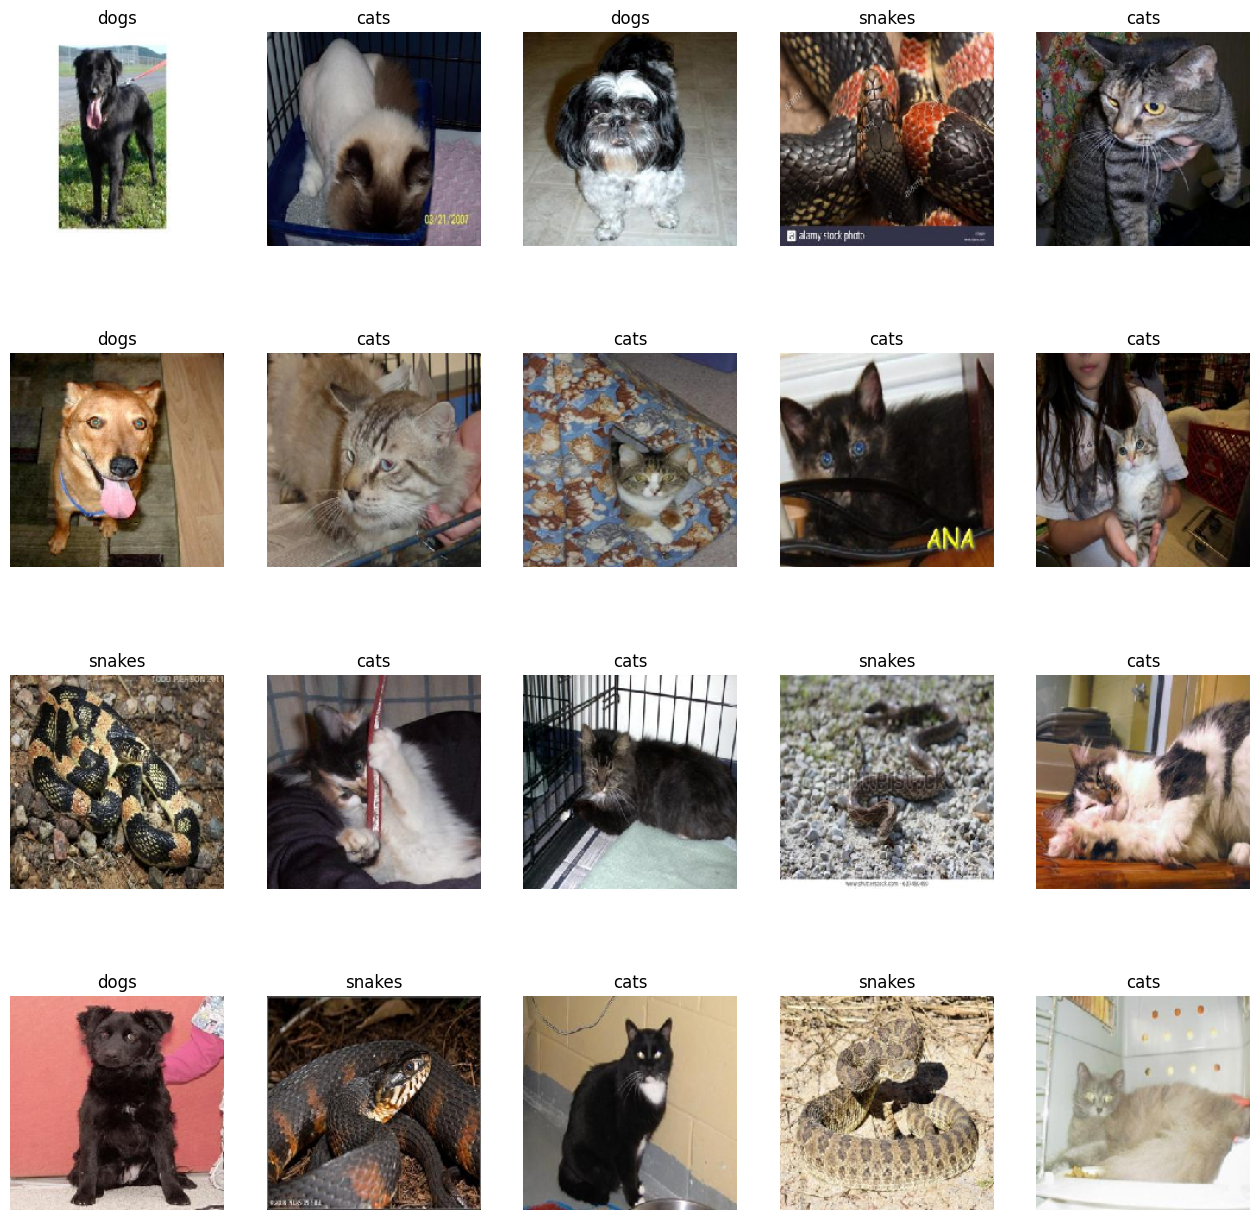

In [8]:
# SHOW AN IMAGE
import matplotlib.pyplot as plt
import numpy as np 

class_names = os.listdir(TRAIN_DIR) # TAKE NAME ALL FOLDER
print(class_names) # CHECK LABEL OF CLASS   

# ITERATE EVERY SAMPLE IMAGE
for image , label in TRAIN_DATA: 

    plt.figure(figsize=(16,16))

    for i in range(20): # DISPLAY 20 IMAGE 
        plt.subplot(4,5,i+1)
        
        plt.imshow(image[i]) 

        animal = tf.argmax(input=label[i])  # TAKE HIGHEST VALUE IN ARRAY . EXAMP = [0 0 1] = 2
        plt.title(class_names[animal]) # IF HIGHEST VALUE = 2 , THEN class_names[2] 
        plt.axis('off')

    break  # STOP AFTER 20 IMAGES, CUZ WE WANT DISPLAY 20 IMAGES ONLY

type(TRAIN_DATA)

# <strong>Create Architecture

In [9]:
import urllib.request

# URL FOR INCEPTIONV3 ARCHITECTURE
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = 'Inception_v3.h5'  #FILENAME 

#DOWNLOAD URL 
urllib.request.urlretrieve(url= weights_url, filename= weights_file)

# LOAD INCEPTION ARCHITECTURE
inception_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top= False,
    weights=None,
    input_shape=(180,180,3)
)

# LOAD PRE-TRAINED INCEPTIONV3 WEIGHT MODEL 
inception_model.load_weights(weights_file)

# SET WEIGHT AND BIAS UNTRAINABLE
for layer in inception_model.layers:
    layer.trainable = False

# TAKE THE INCEPTION LAYERS NAMED 'mixed7'
last_layer = inception_model.get_layer('mixed7')    # U CAN TYPE inception_model.summary() TO SEE THE NAME OF LAYERS
print('last layer shape: ',last_layer.output_shape)

# LAST LAYERS OUTPUT INCEPTIONV3
last_output = inception_model.output                #TAKE 'mixed7' layer as last output layer in inception_model

# ADD CLASSIFICATION LAYERS
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(units=1000,activation='selu')(x)


num_class = 3     # CUZ THE DATASET CONTAINS 3 CLASS/LABEL (CAT, DOG, SNAKE)

# OUTPUT LAYERS
output = tf.keras.layers.Dense(units= num_class, activation='softmax')(x)

# DEFINE MODEL ARCHITECTURE
model = tf.keras.models.Model(inputs = inception_model.input, outputs= output)  # CREATE MODEL

inception_model.output  , inception_model.output_shape  , inception_model.summary()

last layer shape:  (None, 9, 9, 768)
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                  

(<KerasTensor: shape=(None, 4, 4, 2048) dtype=float32 (created by layer 'mixed10')>,
 (None, 4, 4, 2048),
 None)

In [10]:
# CHECK MODEL INFORMATION
#model.output ,     model.output_shape ,     model.layers  

In [11]:
# COMPILE MODEL

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [12]:
# STOP THE TRAINING IF VALIDATION ACCURACY MORE THAN OR EQUAL 0.99 OR TRAINING ACCURACY EQUAL 1

class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        
        if logs['val_accuracy'] >= 0.99 or logs['accuracy'] == 1:
            self.model.stop_training = True
            

# <strong>Train Model

In [13]:
history = model.fit(
    TRAIN_DATA,
    batch_size = 32,
    epochs = 10,
    verbose=1,
    callbacks=[mycallback()],
    validation_data= TEST_DATA
)

Epoch 1/5
75/75 [==============================] - 10s 82ms/step - loss: 5.3172 - accuracy: 0.9212 - val_loss: 0.2280 - val_accuracy: 0.9750
Epoch 2/5
75/75 [==============================] - 5s 66ms/step - loss: 0.2128 - accuracy: 0.9817 - val_loss: 0.4755 - val_accuracy: 0.9783
Epoch 3/5
75/75 [==============================] - 5s 70ms/step - loss: 0.1628 - accuracy: 0.9879 - val_loss: 0.2017 - val_accuracy: 0.9783
Epoch 4/5
75/75 [==============================] - 5s 70ms/step - loss: 0.0732 - accuracy: 0.9900 - val_loss: 0.3197 - val_accuracy: 0.9767
Epoch 5/5
75/75 [==============================] - 5s 70ms/step - loss: 0.1061 - accuracy: 0.9912 - val_loss: 0.3590 - val_accuracy: 0.9733


# <strong>Model Evaluation

<Figure size 640x480 with 0 Axes>

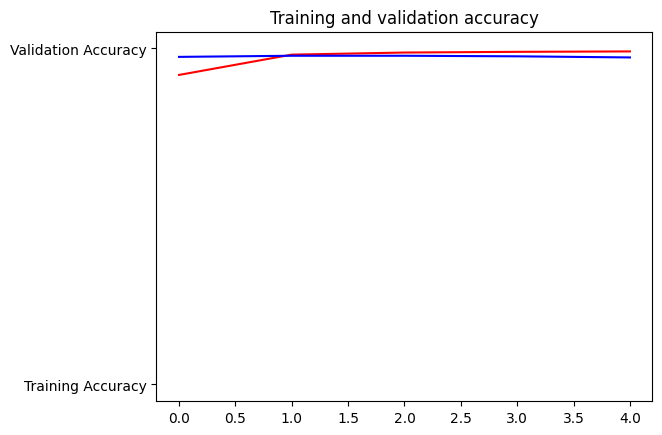

<Figure size 640x480 with 0 Axes>

In [14]:
# VISUALIZE MODEL PERFORMANCE

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

In [15]:
# SHOW LOSS AND ACCURACY METRICS

loss , accuracy = model.evaluate(TEST_DATA)

loss , accuracy

19/19 [==============================] - 1s 49ms/step - loss: 0.3591 - accuracy: 0.9733


(0.359084814786911, 0.9733333587646484)

In [16]:
# EVALUATION

y_true = []    
y_pred = []

# ITERATE OVER TEST_DATA IMAGE AND LABEL
for i, (images , labels) in enumerate(TEST_DATA):
    if i >= 19:
        break
    
    y_hat = np.argmax(model.predict(images, verbose=1), axis=1)  # PREDICT A MODEL AND FIND HIGHEST PROBABILITIES IN EVERY SAMPLE
    
    # PUSH THE PREDICTED LABELS
    y_pred.extend(y_hat)   

    # PUSH THE TRUE LABEL
    y_true.extend(np.argmax(labels, axis=1))

# SHOW EVALUATION RESULT
print('Confusion Matrix : ')
print(classification_report(y_true, y_pred))

KeyboardInterrupt: 

ok lets plot it confusion matrix on heatmap

In [7]:
# HEATMAP

matrix = confusion_matrix(y_true, y_pred)

sns.heatmap(matrix, cmap='viridis', annot=True, fmt= '.2f')

NameError: name 'y_true' is not defined

## <strong>Show Predicted images

In [ ]:
# SHOW PREDICTED IMAGE IN 1 BATCH

plt.figure(figsize=(30,20))

animal = {
    0 : 'Cat',
    1 : 'Dog',
    2 : 'Snake'
}

# TAKE 1 BATCH DATASET (1 BATCH = 32 IMAGES)
for images, labels in TEST_DATA:

    # PREDICT AN IMAGE 
    y_hat = np.argmax( model.predict(images), axis=1) 

    # ITERATE ALL SAMPLES ON 1 BATCH
    for i in range(images.shape[0]): # images.shape = (32, 215, 215, 3)
        
        plt.subplot(4, 8, i+1)
        plt.imshow(images[i])  # .astype() IS USED TO RETURN AN IMAGE TO THE RANGE 0 TO 255

        # MATCH THE LABEL WITH ANIMAL NAMES
        predicted_label = animal[y_hat[i]]
        true_label      = animal[ np.argmax(labels[i]) ]

        plt.title(f'Predicted Label : {predicted_label}', fontsize=22)   # SHOW PREDICTED LABEL
        plt.xlabel(f'True Label : {true_label}', fontsize=22)            # SHOW TRUE LABEL
        plt.box(False)
        
    break  # BREAK AFTER TAKING 1 BATCH

plt.tight_layout()
plt.show()

## <strong> Show False Predicted images

In [ ]:
%%capture

# FIND ALL FALSE PREDICT IMAGE

images = []
predicted_label = []
true_label = []

for i , (image, label) in enumerate(TEST_DATA):

    # STOP AFTER 19 ITERATION (CUZ MAXIMUM BATCH WE HAVE IS 19)
    if i >= 19:
        break
        
    y_hat = np.argmax(model.predict(image), axis=1)
    
    for j in range(image.shape[0]):
        y_true = np.argmax(label[j])
        
        if y_hat[j] != y_true:
            images.append(image[j])
            predicted_label.append(y_hat[j])
            true_label.append(y_true)

In [ ]:
# DISPLAY FALSE PREDICT IMAGE

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12,12))

animals = {
    0 : 'cat',
    1 : 'dog',
    2 : 'snake'
}

for i in range(len(images)):
    axes[i%4, i//4].imshow(images[i])
    axes[i%4, i//4].title(f'Predicted Label : {animals[predicted_label[i]]}')
    axes[i%4, i//4].xlabel(f'True Label : {animals[true_label[i]]}')
    axes[i%4, i//4].box(False)
    

plt.show()

In [13]:
# SAVE A MODEL
# model.save('animal_classification_model.h5')